# Project: authorship attribution

## by: Dekel Mor, Matan Ramati


in this project, our purpose is to classify a text to the most fitting author from number of authors.
in order to do that we will make research to accomplish a few targets: 
* identify useful features from texts
* finding efficient ways to extract that features 
* explore algorithms to find the most suitable and accurate one for the task

The authorship attribution tool can be useful and powerful. until now we had facial recognition, voice recognition, and fingerprint recognition, all of these cant help when you're stuck with a piece of text.
examples for interesting uses: identify impersonators, recognize criminals by text evidence, protect intellectual property, etc.

the Data will be an array that contains an array of text words and labels (author name).
the source of the data can be Facebook posts, letters, opinion pieces, and other texts that are not in strict formal form.





In [1]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('blogtext.csv', delimiter=',')
author_text = dataset[['id','text']]
author_text.head()

,id,text
0,2059027,"Info has been found (+/- 100 pages,..."
1,2059027,These are the team members: Drewe...
2,2059027,In het kader van kernfusie op aarde...
3,2059027,testing!!! testing!!!
4,3581210,Thanks to Yahoo!'s Toolbar I can ...


pre process - tokenize text
and start finding features(Linguistic richness, frequently words):


In [4]:
exampletxt = author_text[2:3].text
mystring = str(exampletxt)

from nltk.tokenize import TweetTokenizer
tweet_tok = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
words_tok = tweet_tok.tokenize(mystring)

print(words_tok)

print(len(set(words_tok))/len(words_tok))

from nltk import FreqDist
FreqDist(words_tok)

['2', 'in', 'het', 'kader', 'van', 'kernfusie', 'op', 'aarde', '...', 'name', ':', 'text', ',', 'dtype', ':', 'object']
0.9375


FreqDist({':': 2, '2': 1, 'in': 1, 'het': 1, 'kader': 1, 'van': 1, 'kernfusie': 1, 'op': 1, 'aarde': 1, '...': 1, ...})

finding features(finding words who frequently located near to some other word):


meet widow athletic very


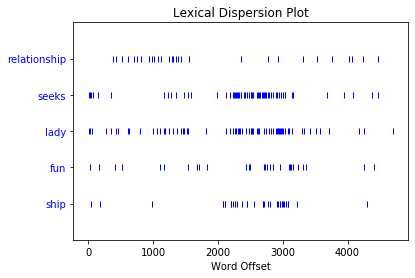

In [9]:
from nltk.book import *

text8.similar("relationship")

import matplotlib as plt;
text8.dispersion_plot(["relationship","seeks","lady","fun","ship"])

as part of the research for the project we will try to find more useful features.

After we will manage to achieve our main target of text authorship attribution and our algorithem will work as accepted our goal is to adjust the algorithm in order to make it run on Hebrew texts as well.
We will try to achieve this goal using excisting open-source tools for Hebrew NLP (Entity recgonition, tokenizing, words tagging etc.) mainley from MILA's (Knowlegde Center For Processing Hebrew) website. (https://yeda.cs.technion.ac.il/eng/index.html) 